In [56]:
import sys
base_path = '/Users/yuri/git/diasYuri/tcc/radiation-forecast-mg'
sys.path.insert(0, base_path)

In [57]:
from pandas import DataFrame
from pydmd import HODMD
from src.dataframe import read_data_from_csv

import matplotlib.pyplot as plt

In [58]:
def get_init(df):
    return df[df.RADIATION.notna()].index[0]


def get_empty_spaces(serie):
    empty_spaces = []
    init = None

    for i, value in enumerate(serie):
        if value == -1:
            if init is None:
                init = i
        else:
            if init is not None:
                empty_spaces.append((init, i))
                init = None

    if init is not None:
        empty_spaces.append((init, len(serie) - 1))

    return empty_spaces


def get_gaps(serie, value_na):
    empty_spaces = []
    init = None

    for i, value in enumerate(serie):
        if value == value_na:
            if init is None:
                init = i
        else:
            if init is not None:
                empty_spaces.append((init, i))
                init = None

    if init is not None:
        empty_spaces.append((init, len(serie) - 1))

    return empty_spaces

def get_fake_data(data, steps):
    length = len(data)
    hodmd = HODMD(svd_rank=0,
                  tlsq_rank=0,
                  exact=True,
                  opt=True,
                  forward_backward=True,
                  sorted_eigs='abs',
                  rescale_mode='auto',
                  reconstruction_method="mean",
                  d=int(length*0.90)) \
        .fit(data.T)

    hodmd.original_time['tend'] = hodmd.dmd_time['tend'] = length-1
    hodmd.dmd_time['tend'] = length+steps-1

    return hodmd.reconstructed_data.T.real[length:]


def data_fill(df: DataFrame, column: str, debug: bool) -> DataFrame:
    dataframe = df[[column]].loc[df.index >= get_init(df)]

    if debug:
        length_df = len(dataframe)
        print('Dataset length: ', length_df)

    index = dataframe.index.values
    real_serie = dataframe.fillna(value=-1).values
    complete_serie = dataframe.fillna(value=-1).values
    empty_spaces = get_empty_spaces(real_serie)
    filler(real_serie, complete_serie, empty_spaces)

    df_complete = DataFrame(complete_serie,
                               index=index,
                               columns =[column])

    return df_complete


def filler(real_serie, complete_serie, empty_spaces):
    for i in range(len(empty_spaces)):
        (idx_l, idx_h) = empty_spaces[i]

        if i > 0:
            (_, last_idx) = empty_spaces[i - 1]

            steps = idx_h - idx_l
            data_input = real_serie[last_idx:idx_l]

            if len(data_input) < 2 or steps > 15:
                data_input = complete_serie[0:idx_l]

            data = get_fake_data(data_input, steps)

            for j in range(idx_l, idx_h):
                complete_serie[j] = data[j - idx_l]



In [59]:
df = read_data_from_csv(f'{base_path}/data/daily_barbacena.csv')

In [60]:
df_complete = data_fill(df, 'RADIATION', False)

/Users/yuri/sdk/miniforge3/envs/tf/lib/python3.9/site-packages/pydmd/hodmd.py:140: UserWarning: The parameter 'svd_rank_extra=0' has been ignored because the given system is a scalar function
  warnings.warn(
/Users/yuri/sdk/miniforge3/envs/tf/lib/python3.9/site-packages/pydmd/utils.py:35: RuntimeWarning: SVD optimal rank is 0. The largest singular values are indistinguishable from noise. Setting rank truncation to 1.
  warnings.warn(


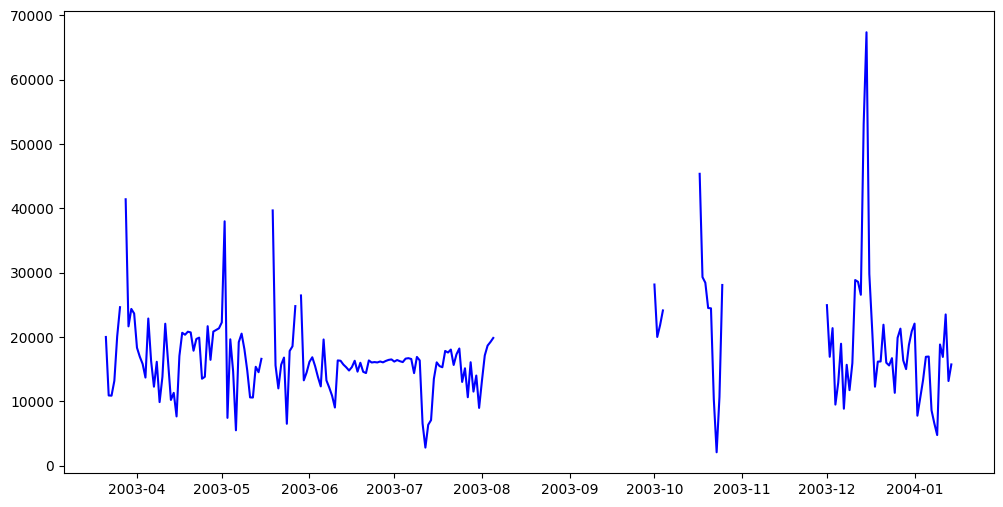

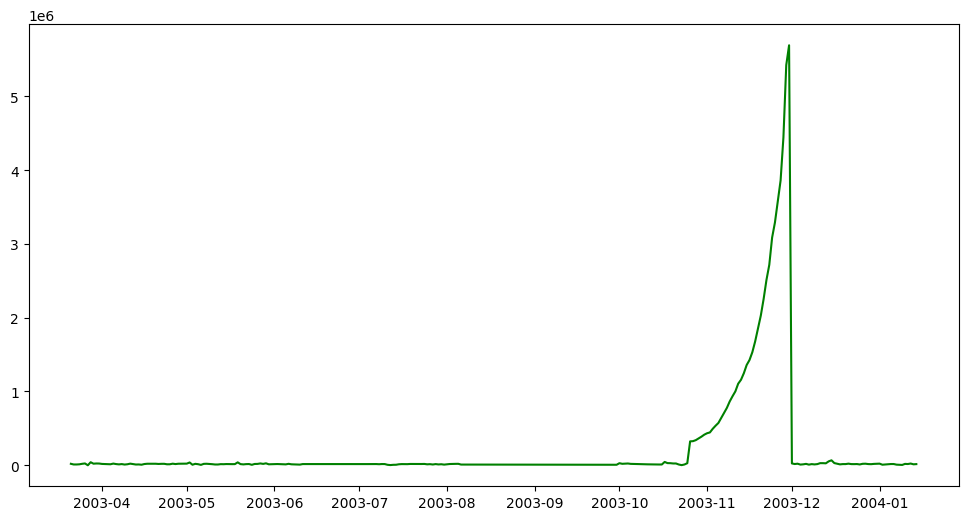

In [61]:
maxrange = 300
plt.figure(figsize=(12, 6))
plt.plot(df['RADIATION'][0:maxrange], color='blue')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df_complete['RADIATION'][0:maxrange], color='green')
plt.show()